In [8]:
import os
import glob

In [19]:
!pwd

/home/gabriele.deleonardis/irbio_folder/code


get mean_FD of rs data and the percentage of volumes above 0.5 threshold

In [ ]:
%cd Desktop/irbio_folder/spreading_dynamics_clinical/

In [5]:
# compute mean FD
import os
import numpy as np
import csv
import re
import pandas as pd
import glob

def process_subject(subject_file):
    # if the input file exists
    if not os.path.isfile(subject_file):
        print(f"File not found: {subject_file}")
        return
    
    subject_id_match = re.search(r"sub-(\d+)_", subject_file)
    
    subject_id = subject_id_match.group(1)

    # Read values from file
    with open(subject_file, 'r') as f:
        values = [float(line.strip()) for line in f if line.strip()]

    if not values:
        print(f"No values to process in {subject_file}")
        return

    # Calculate the mean
    mean_value = np.mean(values)
    threshold = 0.5
    above_threshold = [v for v in values if v > threshold]
    percentage_above_threshold = (len(above_threshold) / len(values)) * 100
    
    return subject_id, mean_value, percentage_above_threshold


output_csv = "mean_FD_rs.tsv"

# Create the CSV file and write the header
with open(output_csv, 'w', newline='') as csvfile:
    csvwriter = csv.writer(csvfile)
    csvwriter.writerow(["Subject", "Mean"])

txt_pattern = os.path.join(os.getcwd(), 'derivatives', 'sub*', 'func', 'sub-*_task-rest_FD.txt')

# Find all CSV files matching the pattern
txt_files = glob.glob(txt_pattern)
results = []
for file in txt_files:
    result = process_subject(file)
    if result:
        results.append(result)
        
results.sort(key=lambda x: int(x[0]))

with open(output_csv, 'w', newline='') as tsvfile:
    tsvwriter = csv.writer(tsvfile, delimiter='\t')
    tsvwriter.writerow(["Subject", "Mean", "Percentage_Above_0.5"])
    tsvwriter.writerows(results)

demographics stats - from preprocessed and post exclusions subjects

In [2]:
import numpy as np
import pandas as pd
import os
import glob
import json
from scipy.stats import ttest_ind
#import pingouin as pg
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import normaltest, mannwhitneyu

In [4]:
%cd ../spreading_dynamics_clinical

/home/gabridele/Desktop/irbio_folder/spreading_dynamics_clinical


In [4]:
import pandas as pd

def txt_to_tsv_with_index(input_txt_file, output_tsv_file):
    # Read the subject IDs from the text file
    with open(input_txt_file, 'r') as file:
        subject_ids = [line.strip() for line in file]

    # Create a DataFrame with subject IDs as index
    df = pd.DataFrame(subject_ids, columns=['Subject_ID'])
    df.set_index('Subject_ID', inplace=True)

    # Write the DataFrame to a TSV file
    df.to_csv(output_tsv_file, sep='\t')

# Specify the input and output files
input_txt_file = 'subject_id_with_exclusions.txt'
output_tsv_file = 'subject_id_with_exclusions.tsv'

# Convert the TXT file to a TSV file
txt_to_tsv_with_index(input_txt_file, output_tsv_file)

print(f"Converted {input_txt_file} to {output_tsv_file} with subject IDs as index.")


Converted subject_id_with_exclusions.txt to subject_id_with_exclusions.tsv with subject IDs as index.


In [7]:
subj_list = 'subject_id_with_exclusions.tsv'
participants_file = 'participants.tsv'
demographics_file = 'phenotype/demographics.tsv'
wais_file = 'phenotype/wais.tsv'

labels = ['age','sex','site','edu_years','mean_FD','wais_mr','wais_lns','wais_voc']
groups = ['CTRL', 'SCZ', 'BPLR', 'ADHD']

In [8]:
# df loading
subjects_df = pd.read_csv(subj_list, delimiter='\t', index_col=0)
df_participants = pd.read_csv(participants_file, sep='\t', index_col=0, header=0)
df_demo = pd.read_csv(demographics_file, sep='\t', index_col=0, header=0)
df_wais = pd.read_csv(wais_file, sep='\t', index_col=0, header=0)

In [10]:
import numpy as np 
#preallocate
age = np.zeros((len(subjects_df.index)))
sex = age.copy()
site = age.copy()
edu_years = age.copy()
hand = age.copy()
wais_mr = age.copy() 
wais_lns = age.copy()
wais_voc = age.copy()

In [11]:
print(subjects_df.index)

Index(['sub-10189', 'sub-10206', 'sub-10217', 'sub-10227', 'sub-10228',
       'sub-10235', 'sub-10273', 'sub-10274', 'sub-10290', 'sub-10292',
       ...
       'sub-70070', 'sub-70073', 'sub-70074', 'sub-70075', 'sub-70076',
       'sub-70077', 'sub-70080', 'sub-70081', 'sub-70083', 'sub-70086'],
      dtype='object', name='Subject_ID', length=166)


In [12]:
print(df_participants)

               diagnosis  age gender  bart  bht  dwi  pamenc  pamret  rest  \
participant_id                                                               
sub-10159        CONTROL   30      F   1.0  NaN  1.0     NaN     NaN   1.0   
sub-10171        CONTROL   24      M   1.0  1.0  1.0     NaN     NaN   1.0   
sub-10189        CONTROL   49      M   1.0  NaN  1.0     NaN     NaN   1.0   
sub-10193        CONTROL   40      M   1.0  NaN  1.0     NaN     NaN   NaN   
sub-10206        CONTROL   21      M   1.0  NaN  1.0     NaN     NaN   1.0   
...                  ...  ...    ...   ...  ...  ...     ...     ...   ...   
sub-70079           ADHD   21      M   1.0  1.0  1.0     1.0     1.0   1.0   
sub-70080           ADHD   48      M   1.0  1.0  1.0     1.0     1.0   1.0   
sub-70081           ADHD   50      M   1.0  1.0  1.0     1.0     1.0   1.0   
sub-70083           ADHD   46      F   1.0  1.0  1.0     1.0     1.0   1.0   
sub-70086           ADHD   48      M   1.0  1.0  1.0     1.0    

In [14]:
import json
demos = []

for idx in df_participants.index:
    if idx in subjects_df.index:
        # Extract data from participants DataFrame
        group = df_participants.loc[idx, 'diagnosis']
        
        age_value = df_participants.loc[idx, 'age']
        
        _sex = df_participants.loc[idx, 'gender']
        sex = 0 if _sex == 'F' else 1
        
        # Extract data from demo DataFrame
        edu_years = int(df_demo.loc[idx, 'school_yrs'])
        
        # Extract data from wais DataFrame
        wais_mr = df_wais.loc[idx, 'mr_totalraw']
        wais_lns = df_wais.loc[idx, 'lns_totalraw']
        wais_voc = df_wais.loc[idx, 'voc_totalraw']
        
        # Initialize variables
        site = None
        
        # Extract data from JSON file
        file = f'{idx}/func/{idx}_task-scap_bold.json'
        try:
            with open(file) as json_data:
                data = json.load(json_data)
                
                if data['SoftwareVersions'] == 'syngo MR B15':
                    site = 1
                elif data['SoftwareVersions'] == 'syngo MR B17':
                    site = 0
        except FileNotFoundError:
            print(f'{idx} doesn\'t have scap task')
        
        # Append the data to the list as a dictionary
        demos.append({
            'subject_id': idx,
            'diagnosis': group,
            'age': age_value,
            'sex': sex,
            'site': site,
            'edu_years': edu_years,
            'wais_mr': wais_mr,
            'wais_lns': wais_lns,
            'wais_voc': wais_voc
        })
demos_df = pd.DataFrame(demos).set_index('subject_id')
print(demos_df)

           diagnosis  age  sex  site  edu_years  wais_mr  wais_lns  wais_voc
subject_id                                                                  
sub-10189    CONTROL   49    1     1         16       22        18        48
sub-10206    CONTROL   21    1     1         13       20        14        35
sub-10217    CONTROL   33    0     1         16       20        22        46
sub-10227    CONTROL   31    0     1         16       24        21        53
sub-10228    CONTROL   40    0     1         13       21        21        38
...              ...  ...  ...   ...        ...      ...       ...       ...
sub-70077       ADHD   23    0     0         16       24        20        39
sub-70080       ADHD   48    1     0         13       17        20        51
sub-70081       ADHD   50    1     0         12       18        22        42
sub-70083       ADHD   46    0     0         16       19        17        29
sub-70086       ADHD   48    1     0         14       19        21        56

In [15]:
# final count divided by diagnosis
# mean divided by diagnosis
print(demos_df['diagnosis'].value_counts())
print(demos_df.groupby('diagnosis')[['age', 'sex', 'site', 'edu_years', 'wais_mr', 'wais_lns', 'wais_voc']].mean())

CONTROL    84
BIPOLAR    34
ADHD       30
SCHZ       18
Name: diagnosis, dtype: int64
                 age       sex      site  edu_years    wais_mr   wais_lns  \
diagnosis                                                                   
ADHD       33.966667  0.533333  0.500000  14.666667  20.566667  20.000000   
BIPOLAR    34.088235  0.500000  0.441176  14.705882  19.794118  19.911765   
CONTROL    31.392857  0.511905  0.797619  15.261905  20.821429  21.035714   
SCHZ       37.277778  0.777778  0.388889  12.944444  13.777778  17.833333   

            wais_voc  
diagnosis             
ADHD       42.700000  
BIPOLAR    43.823529  
CONTROL    44.261905  
SCHZ       29.944444  


In [16]:
# SD divided by diagnosis
print(demos_df.groupby('diagnosis')[['age', 'sex', 'site', 'edu_years', 'wais_mr', 'wais_lns', 'wais_voc']].std())

                 age       sex      site  edu_years   wais_mr  wais_lns  \
diagnosis                                                                 
ADHD       10.169201  0.507416  0.508548   1.917853  4.031628  2.626129   
BIPOLAR     8.680761  0.507519  0.503995   1.850952  4.353887  2.586300   
CONTROL     8.933513  0.502860  0.404188   1.591537  3.862581  2.918353   
SCHZ        8.942993  0.427793  0.501631   1.696787  4.709884  2.640187   

            wais_voc  
diagnosis             
ADHD       10.089769  
BIPOLAR     8.847087  
CONTROL     7.986614  
SCHZ        9.148913  


In [13]:
def extract_fd_values(derivatives_folder):
    """
    Extracts Framewise Displacement (FD) values from the confounds files within the derivatives folder.
    
    Args:
    - derivatives_folder (str): Path to the derivatives folder.
    
    Returns:
    - pd.DataFrame: DataFrame containing statistics of FD values and additional information.
    """
    fd_data_dict = {}

    # Iterate through sub-folders in the derivatives folder
    for root, dirs, files in os.walk(derivatives_folder):
        for sub_dir in dirs:
            if sub_dir.startswith("sub-"):
                func_folder = os.path.join(root, sub_dir, "func")
                if os.path.isdir(func_folder):
                    confounds_file = find_confounds_file(func_folder)
                    if confounds_file:
                        subject_id = sub_dir
                        fd_values = read_fd_values(confounds_file)
                        fd_data_dict[subject_id] = fd_values

    # Convert the dictionary to a DataFrame
    fd_data = pd.DataFrame(fd_data_dict)

    # Calculate statistics for FD values
    statistics_df = calculate_fd_statistics(fd_data)
    return statistics_df

def find_confounds_file(func_folder):
    """
    Finds the confounds file in the functional folder.
    
    Args:
    - func_folder (str): Path to the functional folder.
    
    Returns:
    - str: Path to the confounds file or None if not found.
    """
    confounds_files = [file for file in os.listdir(func_folder) if "-scap_bold_confounds.tsv" in file]
    if confounds_files:
        return os.path.join(func_folder, confounds_files[0])
    return None

def read_fd_values(confounds_file):
    """
    Reads the Framewise Displacement (FD) values from the confounds file.
    
    Args:
    - confounds_file (str): Path to the confounds file.
    
    Returns:
    - pd.Series: Series containing the FD values.
    """
    try:
        confounds_data = pd.read_csv(confounds_file, delimiter="\t")
        return confounds_data["FramewiseDisplacement"]
    except (FileNotFoundError, pd.errors.EmptyDataError, KeyError) as e:
        print(f"Error reading {confounds_file}: {e}")
        return pd.Series(dtype=float)

def calculate_fd_statistics(fd_data):
    """
    Calculates statistics for the FD values.
    
    Args:
    - fd_data (pd.DataFrame): DataFrame containing FD values.
    
    Returns:
    - pd.DataFrame: DataFrame containing statistical measures for the FD values.
    """
    statistics_df = fd_data.describe()

    beyond_02_percentage = (fd_data > 0.2).sum() / fd_data.count() * 100
    beyond_05_percentage = (fd_data > 0.5).sum() / fd_data.count() * 100
    beyond_02_absolute = (fd_data > 0.2).sum()
    beyond_05_absolute = (fd_data > 0.5).sum()

    statistics_df.loc["% > 0.2"] = beyond_02_percentage
    statistics_df.loc["% > 0.5"] = beyond_05_percentage
    statistics_df.loc["Absolute > 0.2"] = beyond_02_absolute
    statistics_df.loc["Absolute > 0.5"] = beyond_05_absolute

    return statistics_df

# Print or save the DataFrame
# final_df.to_excel('output_file.xlsx')
# print(final_df)

In [ ]:
# extract FD values and performs stats. then save to excel file
derivatives = 'derivatives/'
fd_stats = extract_fd_values(derivatives)
fd_excel = fd_stats.T.sort_index()
fd_excel.to_excel('FD_stats.xlsx')

In [22]:
fd_excel = pd.read_excel('scapFD_stats.xlsx', index_col=0, header=0)

In [23]:
# merge FD mean values to demos df
mean_fd_values = fd_excel['mean']
mean_fd_df = pd.DataFrame(mean_fd_values)
mean_fd_df.rename(columns={'mean': 'mean_FD'}, inplace=True)
demos__df = demos_df.merge(mean_fd_df, left_index=True, right_index=True)
demos__df.rename(columns={'diagnosis': 'group'}, inplace=True)
columns = ['group', 'age', 'sex', 'site', 'mean_FD', 'edu_years', 'wais_mr', 'wais_lns', 'wais_voc']
demos__df = demos__df[columns]

In [24]:
demos__df

,group,age,sex,site,mean_FD,edu_years,wais_mr,wais_lns,wais_voc
sub-10189,CONTROL,49,1,1,0.142876,16,22,18,48
sub-10206,CONTROL,21,1,1,0.077702,13,20,14,35
sub-10217,CONTROL,33,0,1,0.064066,16,20,22,46
sub-10227,CONTROL,31,0,1,0.054922,16,24,21,53
sub-10228,CONTROL,40,0,1,0.179278,13,21,21,38
...,...,...,...,...,...,...,...,...,...
sub-70077,ADHD,23,0,0,0.058207,16,24,20,39
sub-70080,ADHD,48,1,0,0.164081,13,17,20,51
sub-70081,ADHD,50,1,0,0.095929,12,18,22,42
sub-70083,ADHD,46,0,0,0.200959,16,19,17,29


In [25]:
# convert vars to integers/float
demos__df['age'] = demos__df['age'].astype(int)
demos__df['mean_FD'] = demos__df['mean_FD'].astype(float)
demos__df['edu_years'] = demos__df['edu_years'].astype(int)
demos__df['wais_mr'] = demos__df['wais_mr'].astype(int)
demos__df['wais_lns'] = demos__df['wais_lns'].astype(int)
demos__df['wais_voc'] = demos__df['wais_voc'].astype(int)

In [31]:
import pingouin as pg
from scipy.stats import mannwhitneyu

labels = ['age', 'sex', 'site', 'mean_FD', 'edu_years', 'wais_mr', 'wais_lns', 'wais_voc']
def all_groups_ttest(df, labels=labels):
    output = ""
    groups = df['group'].unique()
    for label in labels:
        output += f"t-test, Var={label}\n"
        for i, group1 in enumerate(groups):
            for group2 in groups[i+1:]:
                x = df[df['group'] == group1][label].values
                y = df[df['group'] == group2][label].values
                t, p = mannwhitneyu(x, y)
                output += f"\tComparing {group1} vs {group2}:\n"
                output += f"\t  t = {t}\n"
                output += f"\t  p = {p}\n"
                
    output += "\nMeans:\n"
    output += str(df.groupby(['group'])[labels].mean()) + "\n"
    output += "\nStd:\n"
    output += str(df.groupby(['group'])[labels].std()) + "\n"

    return output

def all_groups_stats(df, labels=labels):
    groups = df['group'].unique()
    output = ""  # Initialize the output variable

    for label in labels:
        for i, group1 in enumerate(groups):
            for group2 in groups[i+1:]:
                if label in ['sex', 'site']:
                    new_df = df.loc[(df['group'] == group1) | (df['group'] == group2)]
                    expected, observed, stats = pg.chi2_independence(data=new_df, x=label, y='group')
                    chi2 = np.round(stats.chi2[0], 3)
                    p = np.round(stats.pval[0], 4)
                    print(f"Chi-square test for {label} between {group1} and {group2}:")
                    print(f"\t Chi2 = {chi2}")
                    print(f"\t p = {p}")
                    output += f"Chi-square test for {label} between {group1} and {group2}:\n"
                    output += f"\t Chi2 = {chi2}\n"
                    output += f"\t p = {p}\n"
                else:
                    x = df[df['group'] == group1][label].values
                    y = df[df['group'] == group2][label].values
                    t, p = mannwhitneyu(x, y)
                    print(f"t-test for {label} between {group1} and {group2}:")
                    print(f"\t t = {np.round(t, 3)}")
                    print(f"\t p = {p}")
                    output += f"t-test for {label} between {group1} and {group2}:\n"
                    output += f"\t t = {np.round(t, 3)}\n"
                    output += f"\t p = {p}\n"
                
        # Compute means and std for each label
        output += "\nMeans:\n"
        output += str(df.groupby(['group'])[labels].mean()) + "\n"
        output += "\nStd:\n"
        output += str(df.groupby(['group'])[labels].std()) + "\n"

    return output

In [32]:
stats = all_groups_stats(demos__df)

t-test for age between CONTROL and SCHZ:
	 t = 471.0
	 p = 0.012398123248535177
t-test for age between CONTROL and BIPOLAR:
	 t = 1166.5
	 p = 0.1204745086330879
t-test for age between CONTROL and ADHD:
	 t = 1047.5
	 p = 0.17185374949974652
t-test for age between SCHZ and BIPOLAR:
	 t = 369.5
	 p = 0.22501843239110908
t-test for age between SCHZ and ADHD:
	 t = 322.0
	 p = 0.2719608105087694
t-test for age between BIPOLAR and ADHD:
	 t = 515.0
	 p = 0.9516543181597786
Chi-square test for sex between CONTROL and SCHZ:
	 Chi2 = 3.24
	 p = 0.0719
Chi-square test for sex between CONTROL and BIPOLAR:
	 Chi2 = 0.007
	 p = 0.9314


/home/gabridele/miniconda3/envs/mrtrix3/lib/python3.9/site-packages/pingouin/contingency.py:151: UserWarning: Low count on observed frequencies.
  warnings.warn(f"Low count on {name} frequencies.")
/home/gabridele/miniconda3/envs/mrtrix3/lib/python3.9/site-packages/pingouin/contingency.py:151: UserWarning: Low count on observed frequencies.
  warnings.warn(f"Low count on {name} frequencies.")
/home/gabridele/miniconda3/envs/mrtrix3/lib/python3.9/site-packages/pingouin/contingency.py:151: UserWarning: Low count on observed frequencies.
  warnings.warn(f"Low count on {name} frequencies.")
/home/gabridele/miniconda3/envs/mrtrix3/lib/python3.9/site-packages/pingouin/contingency.py:151: UserWarning: Low count on expected frequencies.
  warnings.warn(f"Low count on {name} frequencies.")


Chi-square test for sex between CONTROL and ADHD:
	 Chi2 = 0.0
	 p = 0.9911
Chi-square test for sex between SCHZ and BIPOLAR:
	 Chi2 = 2.706
	 p = 0.0999
Chi-square test for sex between SCHZ and ADHD:
	 Chi2 = 1.92
	 p = 0.1659
Chi-square test for sex between BIPOLAR and ADHD:
	 Chi2 = 0.0
	 p = 0.9875
Chi-square test for site between CONTROL and SCHZ:
	 Chi2 = 10.467
	 p = 0.0012
Chi-square test for site between CONTROL and BIPOLAR:
	 Chi2 = 12.872
	 p = 0.0003
Chi-square test for site between CONTROL and ADHD:
	 Chi2 = 8.28
	 p = 0.004
Chi-square test for site between SCHZ and BIPOLAR:
	 Chi2 = 0.005
	 p = 0.9457
Chi-square test for site between SCHZ and ADHD:
	 Chi2 = 0.201
	 p = 0.6536
Chi-square test for site between BIPOLAR and ADHD:
	 Chi2 = 0.048
	 p = 0.8262
t-test for mean_FD between CONTROL and SCHZ:
	 t = 457.0
	 p = 0.008786887066525499
t-test for mean_FD between CONTROL and BIPOLAR:
	 t = 1069.0
	 p = 0.033152344395229474
t-test for mean_FD between CONTROL and ADHD:
	 t =

previously excluded those subjects for poor accuracy: \
Poor subjs: 65    sub-10680 \
79    sub-10788 \
Name: participant_id, dtype: object \
Odd HC participant scored: [25.   31.25] % \
Odd HC participant scored: [-5.09257658 -4.56431547] (zscore)

In [ ]:
#save stats to txt file
txt_file_path = 'ttest_results.txt'

# Save the output to a text file
with open(txt_file_path, 'w') as txt_file:
    txt_file.write(stats)

/tmp/ipykernel_1504745/3384716033.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='group', y='age', data=demos__df, palette="Set3")


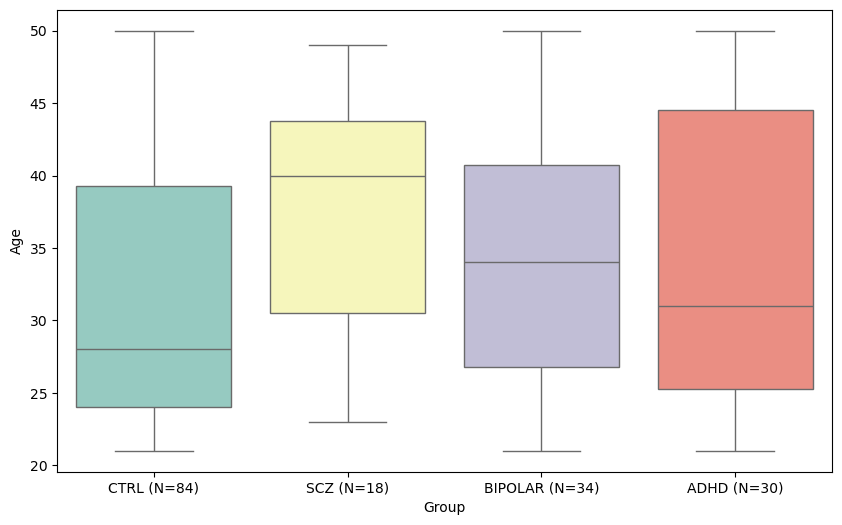

In [ ]:
# create plot
plt.figure(figsize=(10, 6))
sns.boxplot(x='group', y='age', data=demos__df, palette="Set3")
plt.xlabel('')
custom_labels = ["CTRL (N=84)", "SCZ (N=18)", "BIPOLAR (N=34)", "ADHD (N=30)"]
plt.xticks(ticks=range(len(custom_labels)), labels=custom_labels)
plt.ylabel('Age')
plt.title('')
plt.show()

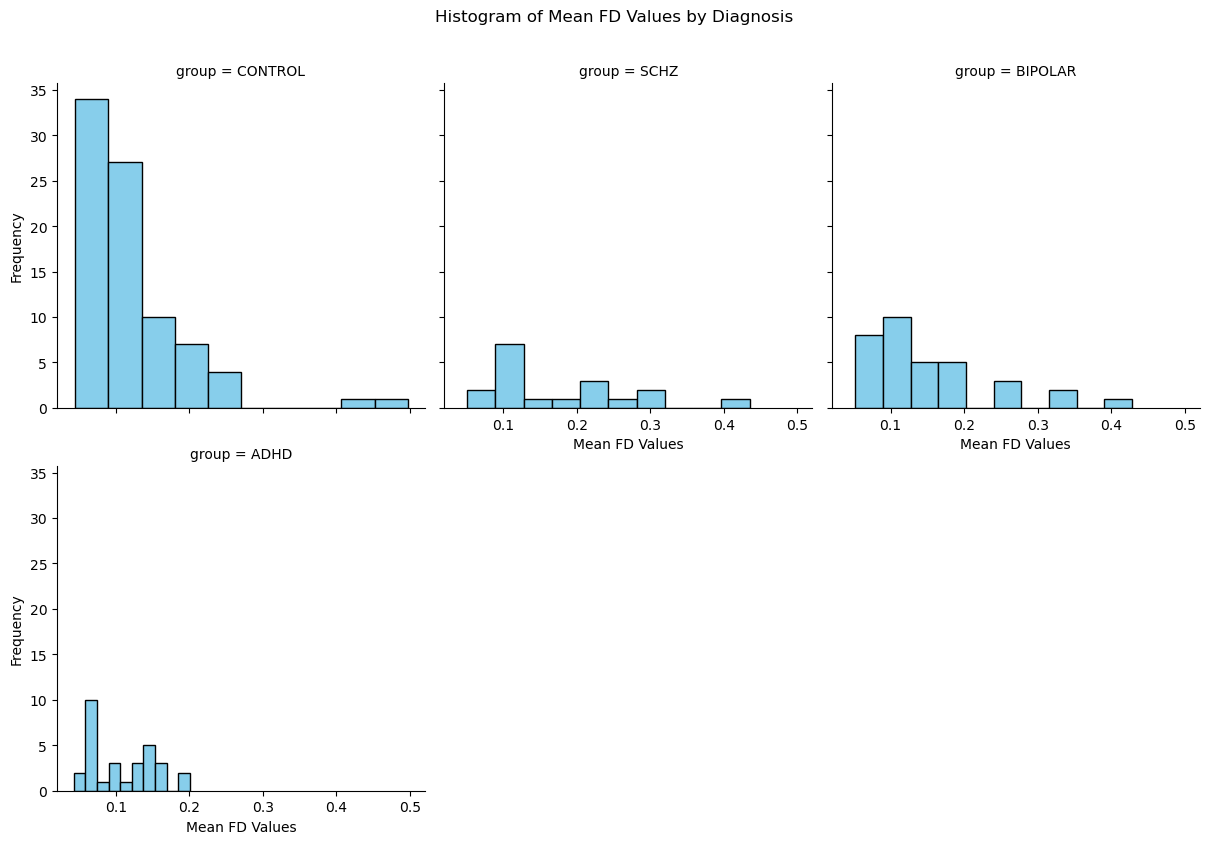

In [ ]:
# visually check for data distribution
# Create a FacetGrid with col_wrap=3
g = sns.FacetGrid(demos__df, col="group", col_wrap=3, height=4)

# Map histograms for the "mean" column
g.map(plt.hist, "mean_FD", bins=10, color='skyblue', edgecolor='black')

# Add labels and title
g.set_axis_labels("Mean FD Values", "Frequency")
g.figure.suptitle("Histogram of Mean FD Values by Diagnosis", y=1.05)

# Show the plot
plt.show()

In [ ]:
# stat test to verify normal distribution
df = demos__df

# Group the data by the "diagnosis" column
grouped = df.groupby("group")

# Perform the normality test for each group
for name, group in grouped:
    print(f"Diagnosis: {name}")
    mean_data = group["mean_FD"]
    statistic, p_value = normaltest(mean_data, nan_policy='omit')
    print(f"Normality Test Statistic: {statistic}")
    print(f"P-value: {p_value}")
    if p_value < 0.05:
        print("The sample does not appear to come from a normal distribution (reject H0)")
    else:
        print("The sample appears to come from a normal distribution (fail to reject H0)")
    print()

Diagnosis: ADHD
Normality Test Statistic: 4.946211855569779
P-value: 0.08432255210182302
The sample appears to come from a normal distribution (fail to reject H0)

Diagnosis: BIPOLAR
Normality Test Statistic: 14.249324225107337
P-value: 0.0008050049652489066
The sample does not appear to come from a normal distribution (reject H0)

Diagnosis: CONTROL
Normality Test Statistic: 71.06484691819772
P-value: 3.7022399516273126e-16
The sample does not appear to come from a normal distribution (reject H0)

Diagnosis: SCHZ
Normality Test Statistic: 5.895340128113729
P-value: 0.052461796286676826
The sample appears to come from a normal distribution (fail to reject H0)



/home/gabridele/miniconda3/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1772: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=18
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


In [ ]:
df = demos__df
# Create a list of unique diagnoses
unique_diagnoses = df['group'].unique()

# Perform Mann-Whitney U test for all pairs of unique diagnoses
for i in range(len(unique_diagnoses)):
    for j in range(i+1, len(unique_diagnoses)):
        diagnosis1 = unique_diagnoses[i]
        diagnosis2 = unique_diagnoses[j]
        
        # Select data for the two diagnoses
        data1 = df[df['group'] == diagnosis1]['mean_FD']
        data2 = df[df['group'] == diagnosis2]['mean_FD']
        
        # Perform Mann-Whitney U test
        stat, p_value = mannwhitneyu(data1, data2, nan_policy='omit')
        
        n1 = len(data1)
        n2 = len(data2)
        
        # Calculate standardized test statistic (z)
        z = (stat - (n1 * n2 / 2)) / np.sqrt(n1 * n2 * (n1 + n2 + 1) / 12)
        
        # Calculate Effect Size (r)
        r = np.abs(z) / np.sqrt(n1 + n2)

        # Convert data1 and data2 to NumPy arrays
        #data1 = np.array(data1)
        #data2 = np.array(data2)

        # Reshape data1 and data2 to have a second dimension
        #data1_reshaped = data1[:, np.newaxis]
        #data2_reshaped = data2[:, np.newaxis]

        # Calculate R
        #R = np.sum(data1_reshaped > data2) + 0.5 * np.sum(data1_reshaped == data2)

        # Calculate CLES
        #cles = (n1 * n2 + R) / (n1 * n2 * 2)
        
        # Print results
        print(f"Mann-Whitney U Test between {diagnosis1} and {diagnosis2}:")
        print(f"U Statistic: {stat}")
        print(f"P-value: {p_value}")
        if p_value < 0.05:
            print("The difference is statistically significant.")
        else:
            print("The difference is not statistically significant.")
        print(f"Effect size between {diagnosis1} and {diagnosis2}: {r}")
        #print(f"Common Language Effect Size (CLES) between {diagnosis1} and {diagnosis2}: {cles}\n")
        print()

Mann-Whitney U Test between CONTROL and SCHZ:
U Statistic: 457.0
P-value: 0.008786887066525499
The difference is statistically significant.
Effect size between CONTROL and SCHZ: 0.2598766247336917

Mann-Whitney U Test between CONTROL and BIPOLAR:
U Statistic: 1069.0
P-value: 0.033152344395229474
The difference is statistically significant.
Effect size between CONTROL and BIPOLAR: 0.19637739093325954

Mann-Whitney U Test between CONTROL and ADHD:
U Statistic: 1308.0
P-value: 0.7598654433808858
The difference is not statistically significant.
Effect size between CONTROL and ADHD: 0.028928788354939172

Mann-Whitney U Test between SCHZ and BIPOLAR:
U Statistic: 359.0
P-value: 0.3125901015521926
The difference is not statistically significant.
Effect size between SCHZ and BIPOLAR: 0.14136801987628098

Mann-Whitney U Test between SCHZ and ADHD:
U Statistic: 383.0
P-value: 0.016584719422798683
The difference is statistically significant.
Effect size between SCHZ and ADHD: 0.34733898263606205


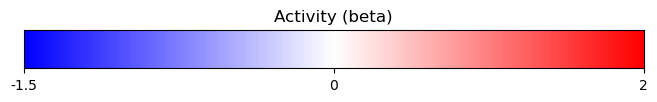

In [5]:
## create custom color map
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as mcolors

# Create a custom colormap that transitions from blue to black to red
cdict = {
    'red':   ((0.0, 0.0, 0.0),  # Blue
              (0.5, 1.0, 1.0),  # White
              (1.0, 1.0, 1.0)), # Red
    'green': ((0.0, 0.0, 0.0),  # Blue
              (0.5, 1.0, 1.0),  # White
              (1.0, 0.0, 0.0)), # Red
    'blue':  ((0.0, 1.0, 1.0),  # Blue
              (0.5, 1.0, 1.0),  # White
              (1.0, 0.0, 0.0))  # Red
}

# Create the colormap using the dictionary
cmap = mcolors.LinearSegmentedColormap('BlueBlackRed', cdict)

# Create a gradient image
gradient = np.linspace(-1.5, 2, 256).reshape(1, -1)
gradient = np.vstack((gradient, gradient))

# Plot the gradient with a shorter height
fig, ax = plt.subplots(figsize=(8, 0.5))
ax.imshow(gradient, aspect='auto', cmap=cmap, extent=[-1.5, 2, 0, 1])
ax.set_yticks([])
ax.set_xticks([-1.5, 0.25, 2])
ax.set_xticklabels(['-1.5', '0', '2'])
ax.set_title('Activity (beta)')

# Show the plot
plt.show()
